This notebook contains code to help explore the dataset. 

In [2]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from data_loader import scores_df

null performances after coercion: 281
after saturation filter 2201
after filter num benchmarks 1401
after merge with model versions 1406
after merge with benchmark dates 1406
Original number of rows: 1406
Number of rows after aggregation: 971


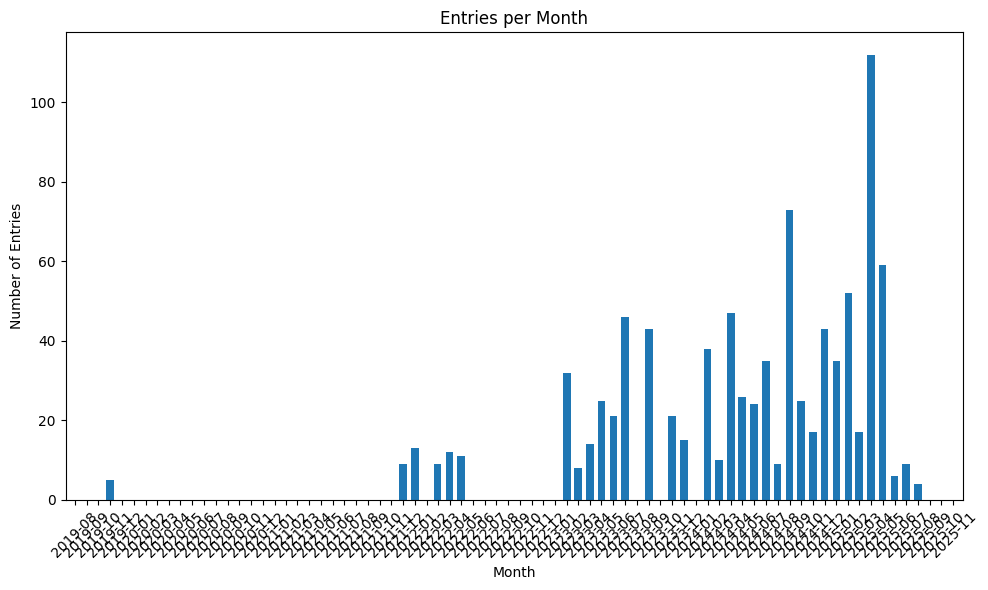

In [4]:
release_times = pd.to_datetime(scores_df['date'])

month_counts = (
    release_times
      .dt.to_period('M')
      .value_counts()
      .sort_index()
)

# convert PeriodIndex back to Timestamp for plotting
months = month_counts.index.to_timestamp()

plt.figure(figsize=(10,6))
plt.bar(months, month_counts.values, width=20)  # width=20 days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Number of Entries')
plt.title('Entries per Month')
plt.tight_layout()
plt.show()

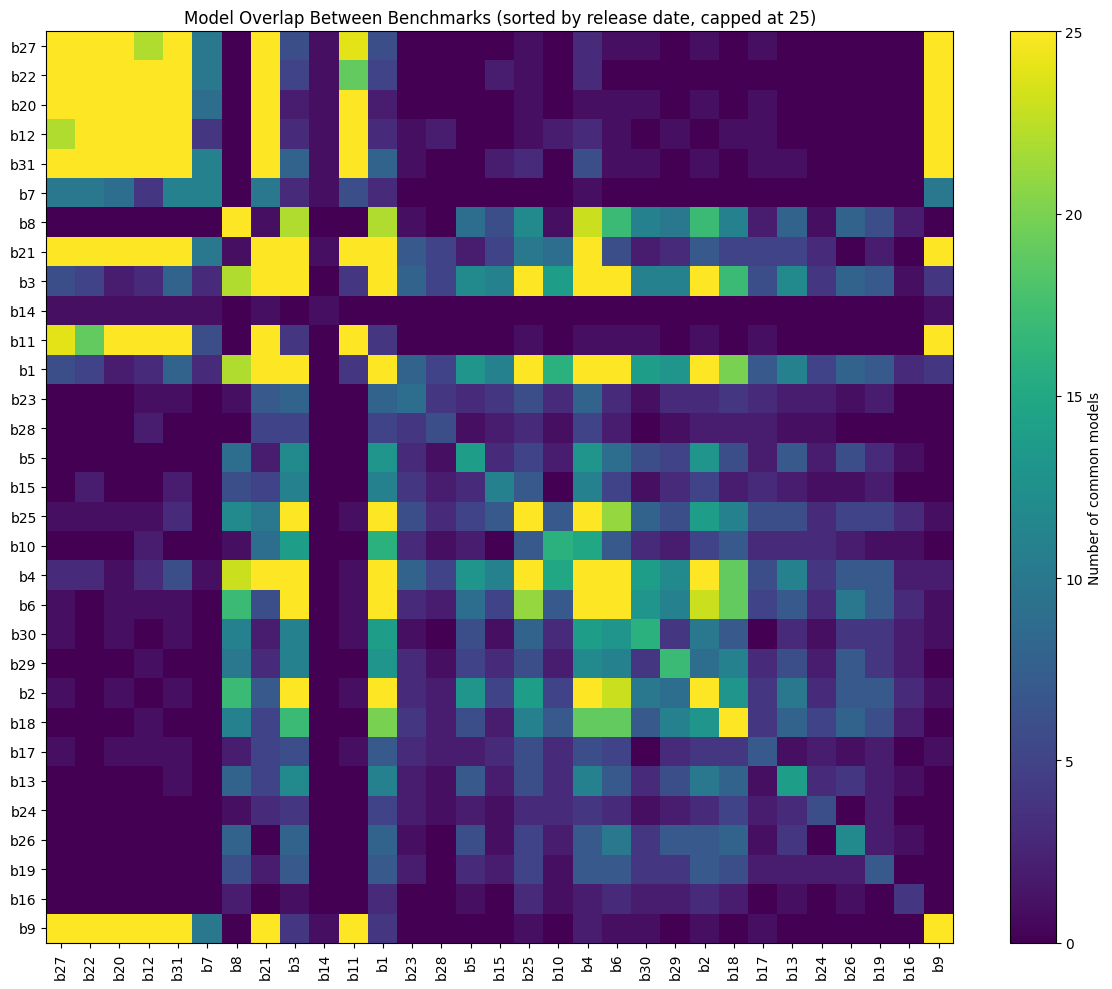

In [5]:
bench_order = (
    scores_df[['benchmark_id', 'benchmark_release_date']]
      .drop_duplicates()
      .sort_values('benchmark_release_date')
      ['benchmark_id']
      .tolist()
)

# 3. Build an empty overlap matrix using that order
overlap = pd.DataFrame(
    0,
    index=bench_order,
    columns=bench_order,
    dtype=int
)

# 4. Precompute which models belong to each benchmark
benchmark_models = {
    b: set(scores_df[scores_df['benchmark_id'] == b]['model_id'])
    for b in bench_order
}

# 5. Fill in overlaps
for b1 in bench_order:
    for b2 in bench_order:
        overlap.loc[b1, b2] = len(benchmark_models[b1].intersection(benchmark_models[b2]))

# 6. Plot heatmap
plt.figure(figsize=(12, 10))
plt.imshow(overlap.values,
          vmin=0,
          vmax=25,
          aspect='auto')
plt.colorbar(label='Number of common models')
plt.xticks(np.arange(len(bench_order)), bench_order, rotation=90)
plt.yticks(np.arange(len(bench_order)), bench_order)
plt.title('Model Overlap Between Benchmarks (sorted by release date, capped at 25)')
plt.tight_layout()
plt.show()

In [6]:
scores_df[["benchmark_id", "benchmark"]].drop_duplicates()

,benchmark_id,benchmark
0,b1,GPQA diamond
1,b10,Balrog
2,b16,DeepResearch Bench
3,b18,GeoBench
4,b2,FrontierMath-2025-02-28-Private
5,b25,SimpleBench
6,b30,WeirdML
7,b4,OTIS Mock AIME 2024-2025
8,b6,Aider polyglot
10,b21,MMLU


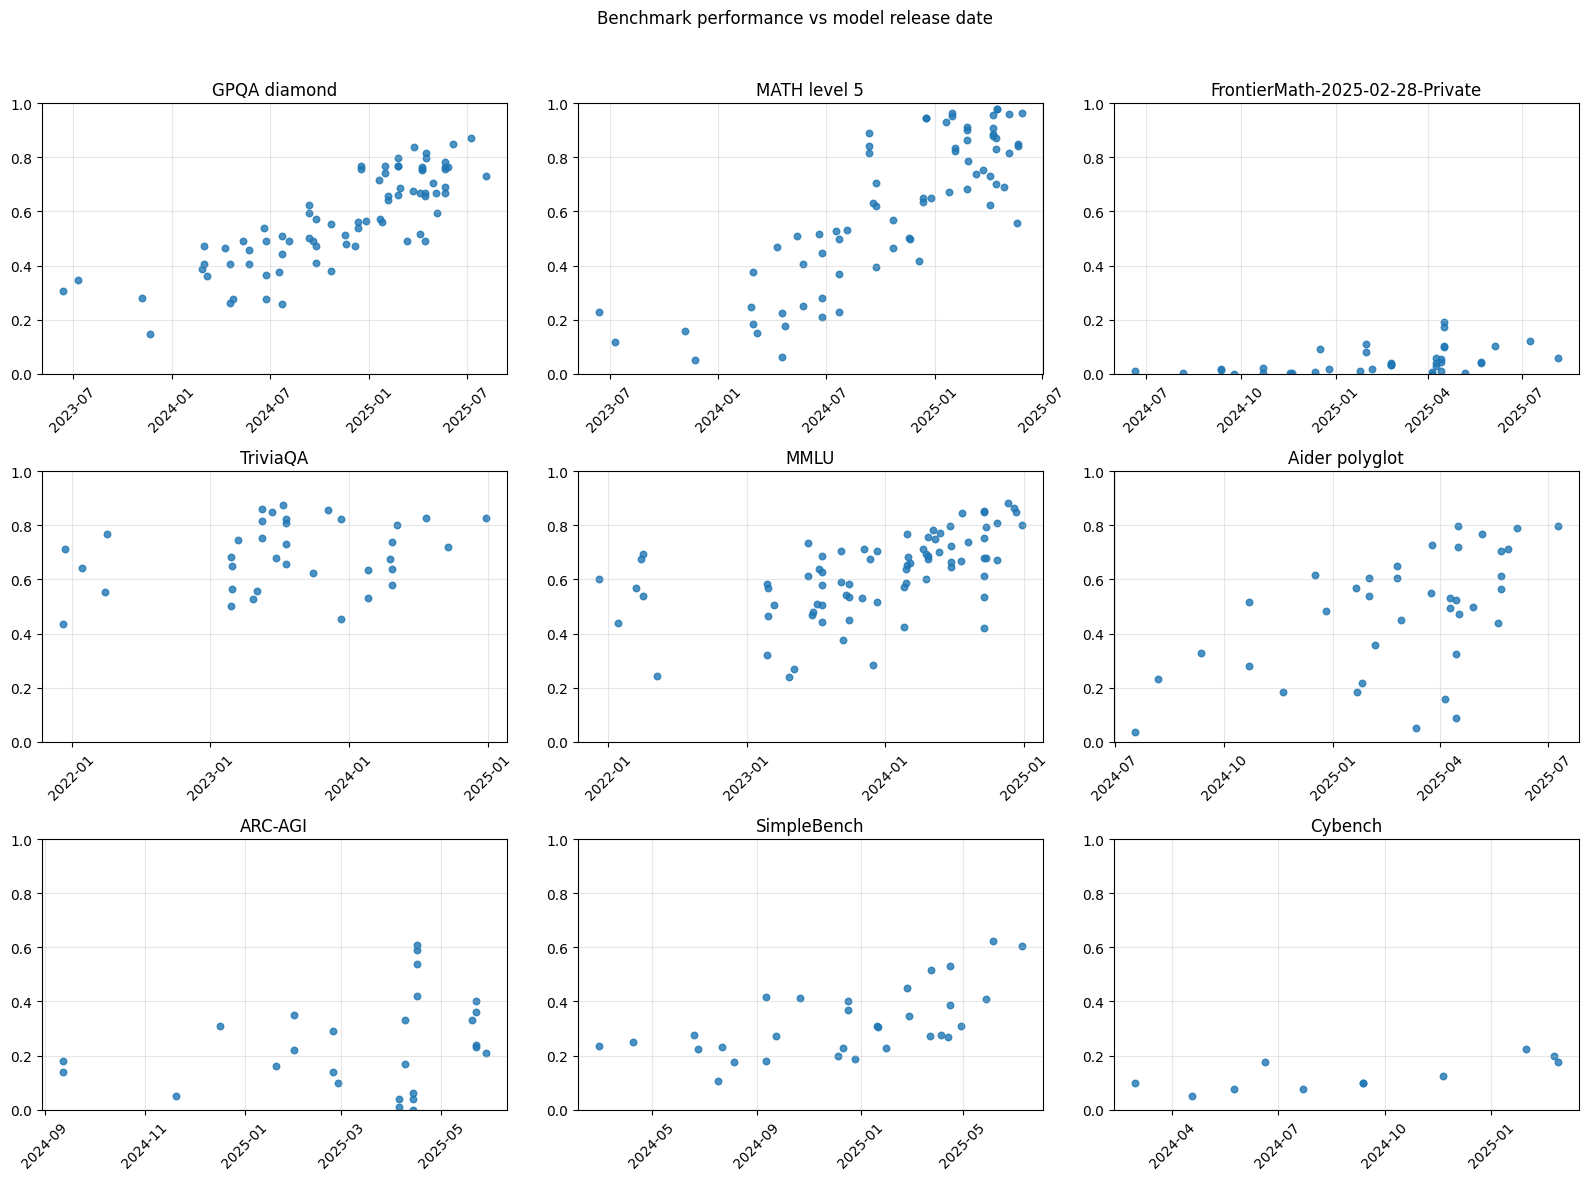

In [15]:
# 3x3 grid: Benchmark performance vs time for selected benchmarks (or random if none specified)
import numpy as np

# Prepare data
_df = scores_df.copy()
_df['date_parsed'] = pd.to_datetime(_df['date'], errors='coerce')

# Specify benchmarks to include (edit this list). If empty, a random selection will be used.
user_selected_benchmarks = [
    "GPQA diamond", "MATH level 5", "FrontierMath-2025-02-28-Private", 
    "TriviaQA", "MMLU", "Aider polyglot",
    "ARC-AGI", "SimpleBench", "Cybench"
]

rng = np.random.default_rng(0)
unique_benchmarks = _df['benchmark'].dropna().unique().tolist()

if len(user_selected_benchmarks) > 0:
    # Validate and keep only those present
    selected_clean = [b for b in user_selected_benchmarks if b in unique_benchmarks]
    missing = [b for b in user_selected_benchmarks if b not in unique_benchmarks]
    if missing:
        print(f"Warning: {len(missing)} benchmarks not found and will be skipped: {missing}")
    selected_benchmarks = np.array(selected_clean)
else:
    # Fallback to random nine
    num_to_draw = min(9, len(unique_benchmarks))
    selected_benchmarks = rng.choice(unique_benchmarks, size=num_to_draw, replace=False)

# Cap at 9 for a 3x3 grid
if len(selected_benchmarks) > 9:
    print(f"Note: More than 9 specified; showing the first 9: {selected_benchmarks[:9].tolist()}")
    selected_benchmarks = selected_benchmarks[:9]

num_to_plot = len(selected_benchmarks)

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(16, 12), sharey=True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= num_to_plot:
        fig.delaxes(ax)
        continue
    bench = selected_benchmarks[i]
    sub = (
        _df[_df['benchmark'] == bench]
        .dropna(subset=['date_parsed', 'performance'])
        .sort_values('date_parsed')
    )
    ax.scatter(sub['date_parsed'], sub['performance'], s=22, alpha=0.8)
    ax.set_title(str(bench))
    ax.set_ylim(0, 1)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=6))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.grid(True, alpha=0.3)

    # Ensure tick labels show on all subplots (not just edge axes)
    ax.tick_params(labelbottom=True, labelleft=True)
    for lbl in ax.get_xticklabels():
        lbl.set_visible(True)
    for lbl in ax.get_yticklabels():
        lbl.set_visible(True)

fig.suptitle('Benchmark performance vs model release date')
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [21]:
pd.read_csv("https://epoch.ai/data/all_ai_models.csv")["Notability criteria"]

0                           NaN
1                 Miscellaneous
2                 Miscellaneous
3                           NaN
4                           NaN
                 ...           
2612    Historical significance
2613    Historical significance
2614    Historical significance
2615                        NaN
2616                        NaN
Name: Notability criteria, Length: 2617, dtype: object

In [25]:
# Fraction of models in scores_df that are notable per Epoch all_ai_models (using model name mapping)
import pandas as pd

# Map model IDs in scores_df to human-readable names using model_versions.csv
_mv = pd.read_csv("data/model_versions.csv")[["id", "Model"]].rename(columns={"id": "model"})
_unique_ids = scores_df[["model"]].drop_duplicates()
_unique_with_names = _unique_ids.merge(_mv, on="model", how="left")

# Use the mapped name when available; fall back to the ID string
_unique_with_names["model_name"] = _unique_with_names["Model"].fillna(_unique_with_names["model"].astype(str))
_unique_with_names["model_norm"] = _unique_with_names["model_name"].astype(str).str.lower().str.strip()

# Load Epoch's all_ai_models.csv and normalize
_df_all = pd.read_csv("https://epoch.ai/data/all_ai_models.csv")
_name_candidates = [
    "Model", "Name", "Model name", "Model Name", "model", "name", "model_name"
]
_name_col = next((c for c in _name_candidates if c in _df_all.columns), None)

if _name_col is None:
    print("Could not find a model name column in all_ai_models.csv; available columns:")
    print(list(_df_all.columns))
else:
    _df_all = _df_all.copy()
    _df_all["model_norm"] = _df_all[_name_col].astype(str).str.lower().str.strip()
    _df_all_norm = _df_all[["model_norm", "Notability criteria", _name_col]].drop_duplicates(subset=["model_norm"])

    # Merge normalized names to attach notability
    _merged = _unique_with_names.merge(_df_all_norm, on="model_norm", how="left")
    _merged["is_notable"] = _merged["Notability criteria"].notna()

    _total = len(_merged)
    _num_notable = int(_merged["is_notable"].sum())
    _frac_notable = _num_notable / _total if _total else float("nan")

    print(f"Unique model IDs in scores_df: {_total}")
    print(f"Models with non-NaN 'Notability criteria': {_num_notable}")
    print(f"Fraction notable: {_frac_notable:.3f}")

    # Diagnostics
    _num_missing_names = int(_unique_with_names["Model"].isna().sum())
    if _num_missing_names:
        print(f"Warning: {_num_missing_names} model IDs lacked a name in model_versions.csv (using ID as fallback).")

    _missing_examples = _merged.loc[~_merged["is_notable"], "model_name"].head(20).tolist()
    if _missing_examples:
        print("Examples without 'Notability criteria':", _missing_examples)



Unique model IDs in scores_df: 151
Models with non-NaN 'Notability criteria': 79
Fraction notable: 0.523
Examples without 'Notability criteria': ['Gemma 2 27B', 'Falcon-7B', 'MPT-7B', 'chatglm2-6b', 'internlm-7b', 'internlm-20b', 'Claude 3 Haiku', 'Baichuan 2-7B', 'Baichuan2-13B', 'LLaMA-33B', 'Stable Beluga 2', 'Qwen-1_8B', 'Qwen-7B', 'Qwen-14B', 'Nemotron-4 15B', 'MPT-30B', 'PaLM 62B', 'DeepSeek-V2 (MoE-236B)', 'Gemma 2B', 'Qwen2.5-Coder-0.5B']
